# Check / Install Dependencies

In [1]:
# It is best to get all of these packages installed in your conda environment before running this notebook.

# Python dependencies
import os, sys
import subprocess
import numpy
import parmed
import six
import torch
import bs4
import mechanize
import multiprocessing as mp
import psutil
import ase
import matplotlib.pyplot as plt

# InterMol installation
os.chdir(os.path.join('Convert_Gromacs_LAMMPS','InterMol'))
os.system('python setup.py build')
os.system('python setup.py install')
os.chdir(os.path.join('..','..'))

# GROMACS dependency
gmx_exec = subprocess.check_output('which gmx', shell=True).decode()[:-1]
assert gmx_exec.endswith('gromacs/bin/gmx')

# Flag
dependencies = True

# Baseline Protein Energy Calculation

In [2]:
## Here we will convert the baseline standalone protein structures (*.pdb) into GROMACS format and 
## then converted into LAMMPS format. We will then perform a single-snapshot energy calculation using 3T model.
## This helps us ensure that the necessary libraries are installed correctly (GROMACS, InterMol, PyTorch) for 3T.
## However, there is no ligand force field parametrization in this step (SwissParam webserver),
## so that functionality can only be tested in subsequent steps.
## The input structure preparation (GROMACS, LAMMPS) may take several minutes.
## On a GPU machine, the 3T energy calculation step should be instantenous.

assert (dependencies==True)

from convert_baseline import calculate_baseline
calculate_baseline('1fin_ENS_dH')
calculate_baseline('1uyg_ENS')
calculate_baseline('1ezq_ENS_dH')


Converting the protein structure 1fin_ENS_dH.pdb into GROMACS format...
Converting the GROMACS format into LAMMPS format...
Loading LAMMPS format into 3T model and calculating energy...
Baseline protein energy written onto /media/sf_ShareVM/Python_Code/Github/3T/2_structure_generation/temp_0/../Converted_Structures/1fin_ENS_dH/PRO_outE.txt

Converting the protein structure 1uyg_ENS.pdb into GROMACS format...
Converting the GROMACS format into LAMMPS format...
Loading LAMMPS format into 3T model and calculating energy...
Baseline protein energy written onto /media/sf_ShareVM/Python_Code/Github/3T/2_structure_generation/temp_0/../Converted_Structures/1uyg_ENS/PRO_outE.txt

Converting the protein structure 1ezq_ENS_dH.pdb into GROMACS format...
Converting the GROMACS format into LAMMPS format...
Loading LAMMPS format into 3T model and calculating energy...
Baseline protein energy written onto /media/sf_ShareVM/Python_Code/Github/3T/2_structure_generation/temp_0/../Converted_Structures/1ez

# Input File Selection

In [3]:
## In 2022, it is computationally unwise to repeat the entire paper's structure generation on a single machine.
## In this example, we will pick one ligand for each of the 3 proteins and generate protein-ligand pocket
## complex geometries for these 3 protein-ligand pairs.

# First, we need to extract the folders containing ALL the ligand input files used in the paper.
import os
os.chdir('Input_File_Storage')
os.system('tar -xf CDK2.tar.gz')
os.system('tar -xf HSP90.tar.gz')
os.system('tar -xf FXA.tar.gz')
os.chdir('..')

In [4]:
## Next, we will be modest and grab one ligand (*.mol2 and *.rotbond file needed) for each protein.
## These ligands' coordinates have previously been docked onto the protein pocket using smina.
## These complexes will be our initial structures, equivalent to those generated by standard rigid protein docking.

os.system('rm -r Input_Structures/1fin_ENS_dH/Ligands/*')
os.system('rm -r Input_Structures/1uyg_ENS/Ligands/*')
os.system('rm -r Input_Structures/1ezq_ENS_dH/Ligands/*')

inp = 'Input_File_Storage/CDK2/cocry_2iw8_4SP_LIG_dock_1FIN_1'
outp = 'Input_Structures/1fin_ENS_dH/Ligands/CDK2_dock/'
os.system('mkdir '+outp)
os.system('cp '+inp+'* '+outp)

inp = 'Input_File_Storage/HSP90/cocry_2fwy_H64_LIG_dock_1uyg_1'
outp = 'Input_Structures/1uyg_ENS/Ligands/HSP90_dock/'
os.system('mkdir '+outp)
os.system('cp '+inp+'* '+outp)

inp = 'Input_File_Storage/FXA/cocry_2d1j_D01_LIG_dock_1ezq_1'
outp = 'Input_Structures/1ezq_ENS_dH/Ligands/FXA_dock/'
os.system('mkdir '+outp)
os.system('cp '+inp+'* '+outp)


## If you want to run the entire ligand sets on a single machine (not recommended), uncomment this block:
##inp = 'Input_File_Storage/CDK2/'
##outp = 'Input_Structures/1fin_ENS_dH/Ligands/CDK2_dock/'
##os.system('mkdir '+outp)
##os.system('cp '+inp+'* '+outp)
##inp = 'Input_File_Storage/HSP90/'
##outp = 'Input_Structures/1uyg_ENS/Ligands/HSP90_dock/'
##os.system('mkdir '+outp)
##os.system('cp '+inp+'* '+outp)
##inp = 'Input_File_Storage/FXA/'
##outp = 'Input_Structures/1ezq_ENS_dH/Ligands/FXA_dock/'
##os.system('mkdir '+outp)
##os.system('cp '+inp+'* '+outp)

0

In [5]:
## We will also choose our 3T generation hyperparameters. On 1 NVIDIA T4 GPU, generating 1 protein-ligand complex
## conformation takes around 12 minutes on average. On 1 NVIDIA V100 GPU, it should be >2x faster.
## On a 64-core CPU, it takes 2 hours & 45 minutes to generate 64 conformations in parallel. You should budget this
## example testing based on your own computation resources. We will proceed with generating
## only 1 conformation / protein. This may take 36-45 minute on a low-end GPU like T4, or 9 hours on single-core CPU.
config_folder = 'Config_Files/Short_Test_Configs/'

## If you have sufficiently good GPU and would like 10 conformations per complex instead, uncomment this line:
##config_folder = 'Config_Files/Paper_Configs/'

# Ligand Force Field Parametrization & 3T Structure Generation

In [6]:
def cleanup_folder(path1):
    dirs = os.listdir(path1)
    for dir_ in dirs:
        path2 = os.path.join(path1,dir_)
        if os.path.isdir(path2):
            dirs2 = os.listdir(path2)
            for dir2_ in dirs2:
                full_path = os.path.join(path2,dir2_)
                if os.path.isdir(full_path):
                    os.system('rm -r '+full_path)

## Uncomment the block below if you want to clean up the 'Converted_Structures' and 'Minimized_Structures' folders.
## We recommend cleaning up if you are starting a fresh run, and commenting these out if your session crashes due
## to external problems and would like to continue from where you left off.

cleanup_folder('Converted_Structures')
cleanup_folder('Minimized_Structures')

In [7]:
## Here we will call exec_workflow.py. This script takes a json config file, which specifies the base protein to run,
## as well as other structure generation settings (kick strength, # of conformations, etc). Check the 'Config_Files'
## folder for more detail.
## The behavior of exec_workflow.py depends on the machine being used. On a GPU machine, it is a single-process code.
## On an n-core CPU machine, it is an n-processes code simultaneously working on n different ligands. All ligands 
## within the baseline protein folder in the 'Input_Structures' folder will be processed, and split between the 
## processes. Each process will then generate the required # of structure conformations, based on 
## the random number seeds being used.
## We also ensure that completed tasks are not repeated. If the output files for each step (force field assignment,
## ligand relaxation, pocket relaxation) are detected, the corresponding step will be skipped. This is useful for
## large scale structure generation. 

assert (dependencies==True)
from exec_workflow import main as main_exec

main_exec(config_folder+'CDK2.json')
main_exec(config_folder+'HSP90.json')
main_exec(config_folder+'FXA.json')

Utilizing Config_Files/Short_Test_Configs/CDK2.json config file...
Config file content:
{'protein': '1fin_ENS_dH', 'ligand_epoch': 11, 'complex_epochs': [11, 11], 'kick_center': [-13.094694, 205.03195, 114.42654], 'kick_radius': 20.0, 'kick_strength': 5.0, 'print_freq': 10, 'conformers': 1, 'init_random_seed': 12345}

We are using 1 CPUs
Working on protein:
1fin_ENS_dH
Pocket docked with ligand:
CDK2_dock/cocry_2iw8_4SP_LIG_dock_1FIN_1
Parametrizing ligand force field and converting to GROMACS-LAMMPS format...
3T ligand relaxation within rigid protein pocket...
Step:0
Step:10
3T energetic kick & pocket relaxation...
Energetic kick random seed: 86498
Step:0
Step:10
Step:0
Step:10
Finish 1/1 jobs


Utilizing Config_Files/Short_Test_Configs/HSP90.json config file...
Config file content:
{'protein': '1uyg_ENS', 'ligand_epoch': 11, 'complex_epochs': [11, 11], 'kick_center': [2.3558855375608507, 10.045364266083117, 24.995132864932174], 'kick_radius': 20.0, 'kick_strength': 5.0, 'print_freq':

In [8]:
## At this point, the generates structures will be located in the 'Minimized_Structures' folder.

print('Generated CDK2 protein-ligand complex folders:')
name = 'Minimized_Structures/1fin_ENS_dH/CDK2_dock/'
print(name), print(os.listdir(name)), print('')

print('Generated HSP90 protein-ligand complex folders:')
name = 'Minimized_Structures/1uyg_ENS/HSP90_dock/'
print(name), print(os.listdir(name)), print('')

print('Generated FXA protein-ligand complex folders:')
name = 'Minimized_Structures/1ezq_ENS_dH/FXA_dock/'
print(name), print(os.listdir(name)), print('')

Generated CDK2 protein-ligand complex folders:
Minimized_Structures/1fin_ENS_dH/CDK2_dock/
['cocry_2iw8_4SP_LIG_dock_1FIN_1']

Generated HSP90 protein-ligand complex folders:
Minimized_Structures/1uyg_ENS/HSP90_dock/
['cocry_2fwy_H64_LIG_dock_1uyg_1']

Generated FXA protein-ligand complex folders:
Minimized_Structures/1ezq_ENS_dH/FXA_dock/
['cocry_2d1j_D01_LIG_dock_1ezq_1']



(None, None, None)

10 conformations for:
CDK2 complex (1fin_2iw8-4SP)
HSP90 complex (1uyg_2fwy-H64)
FXA complex (1ezq_2d1j-D01)


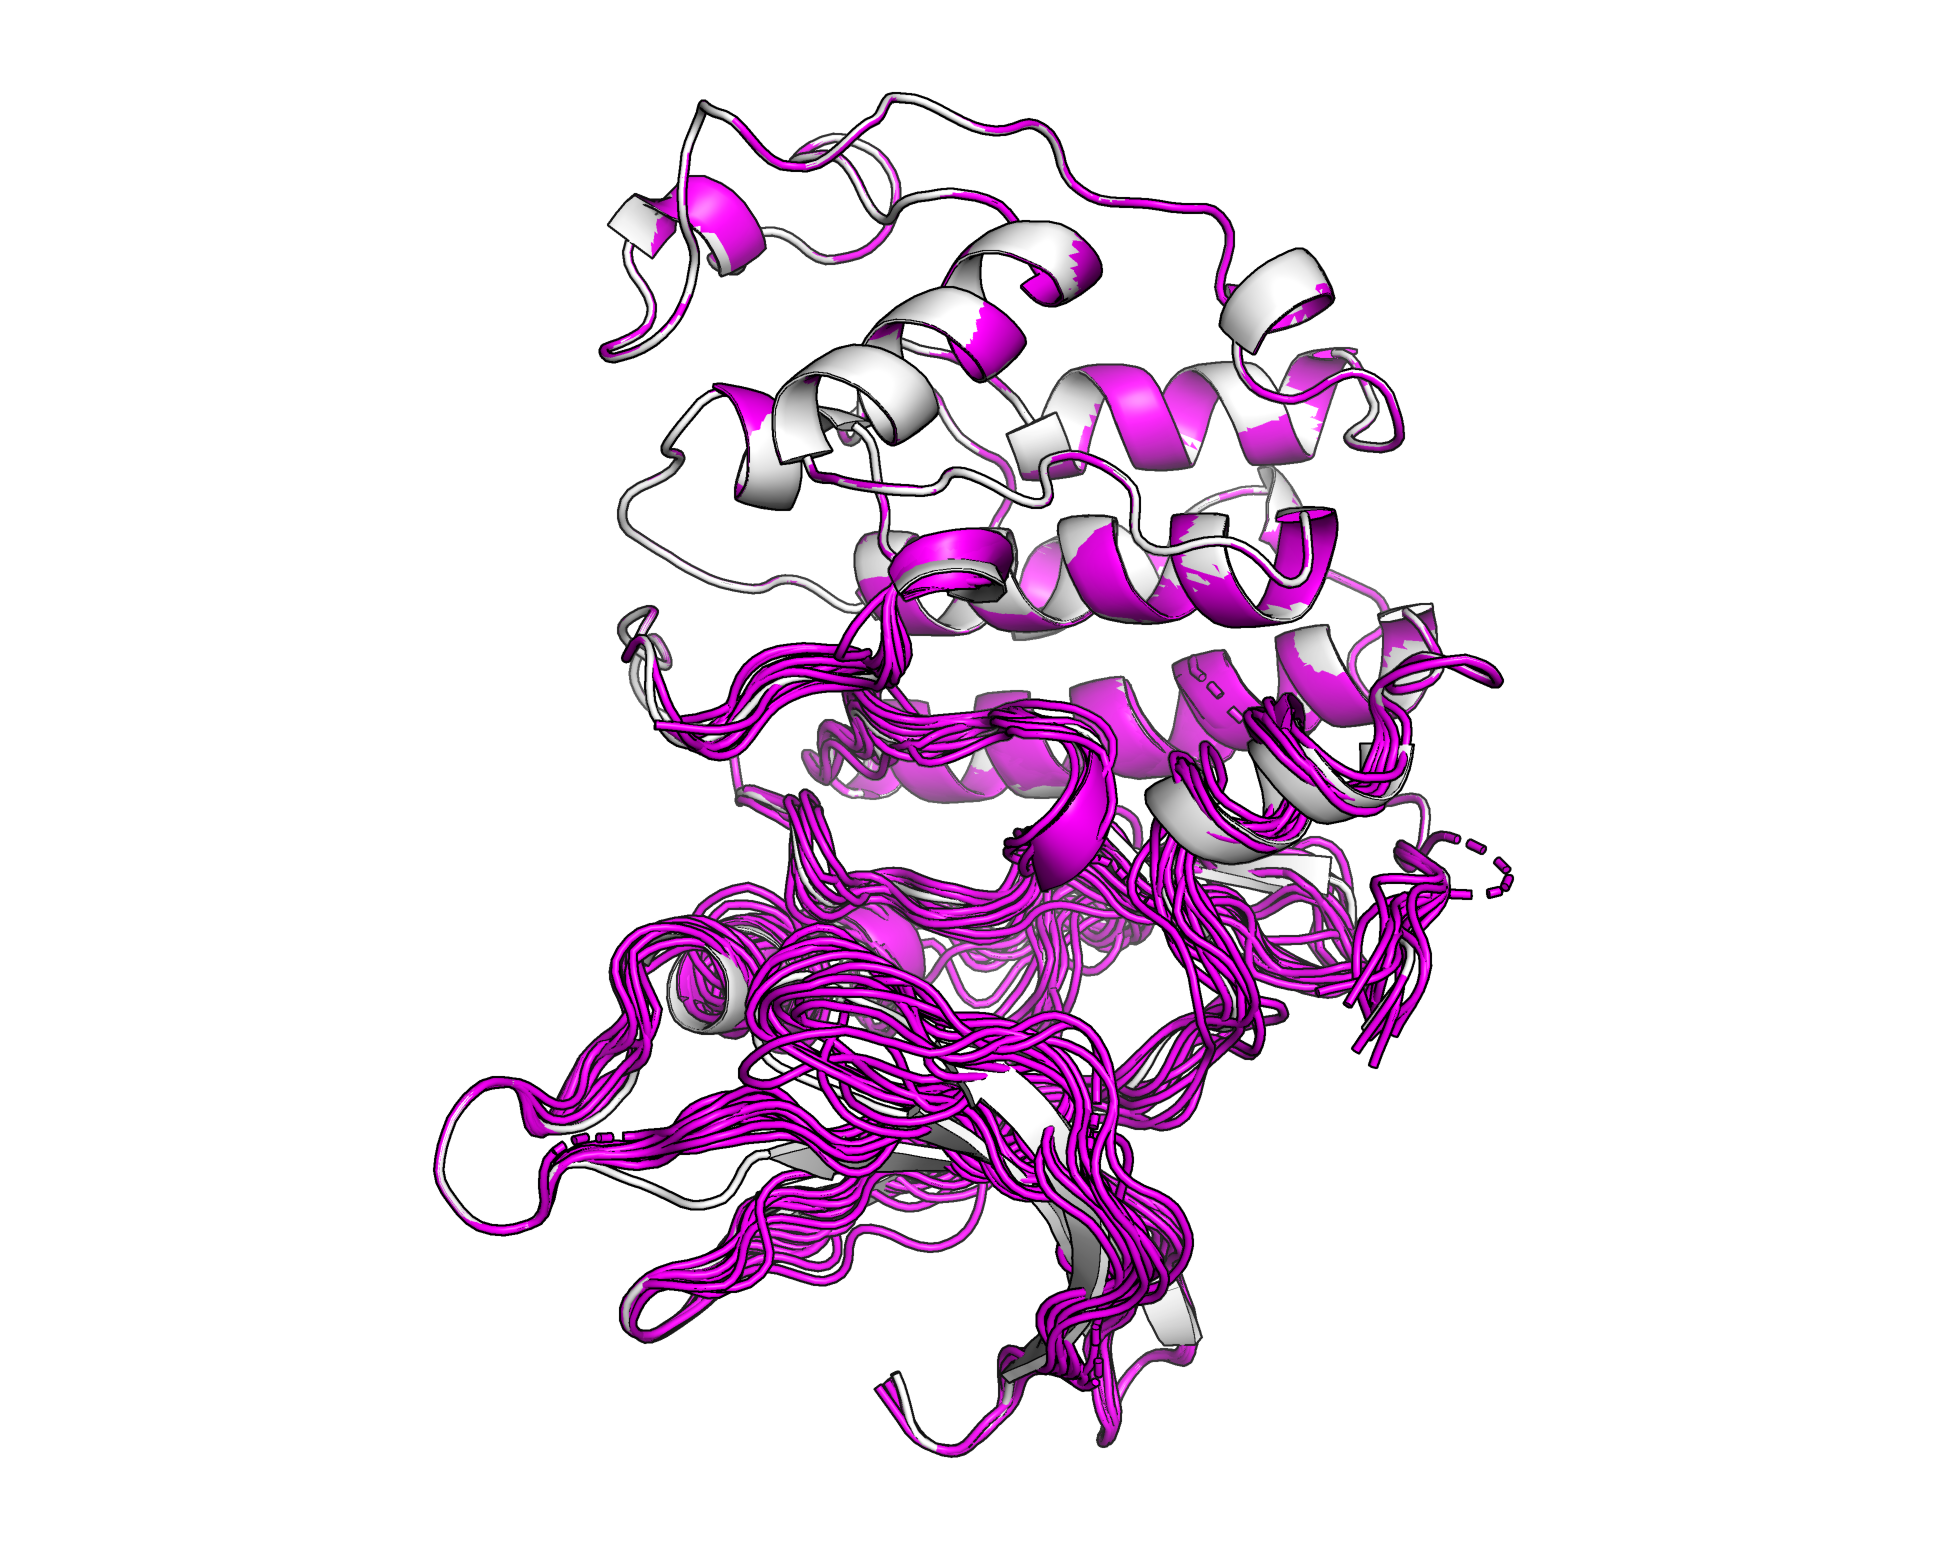

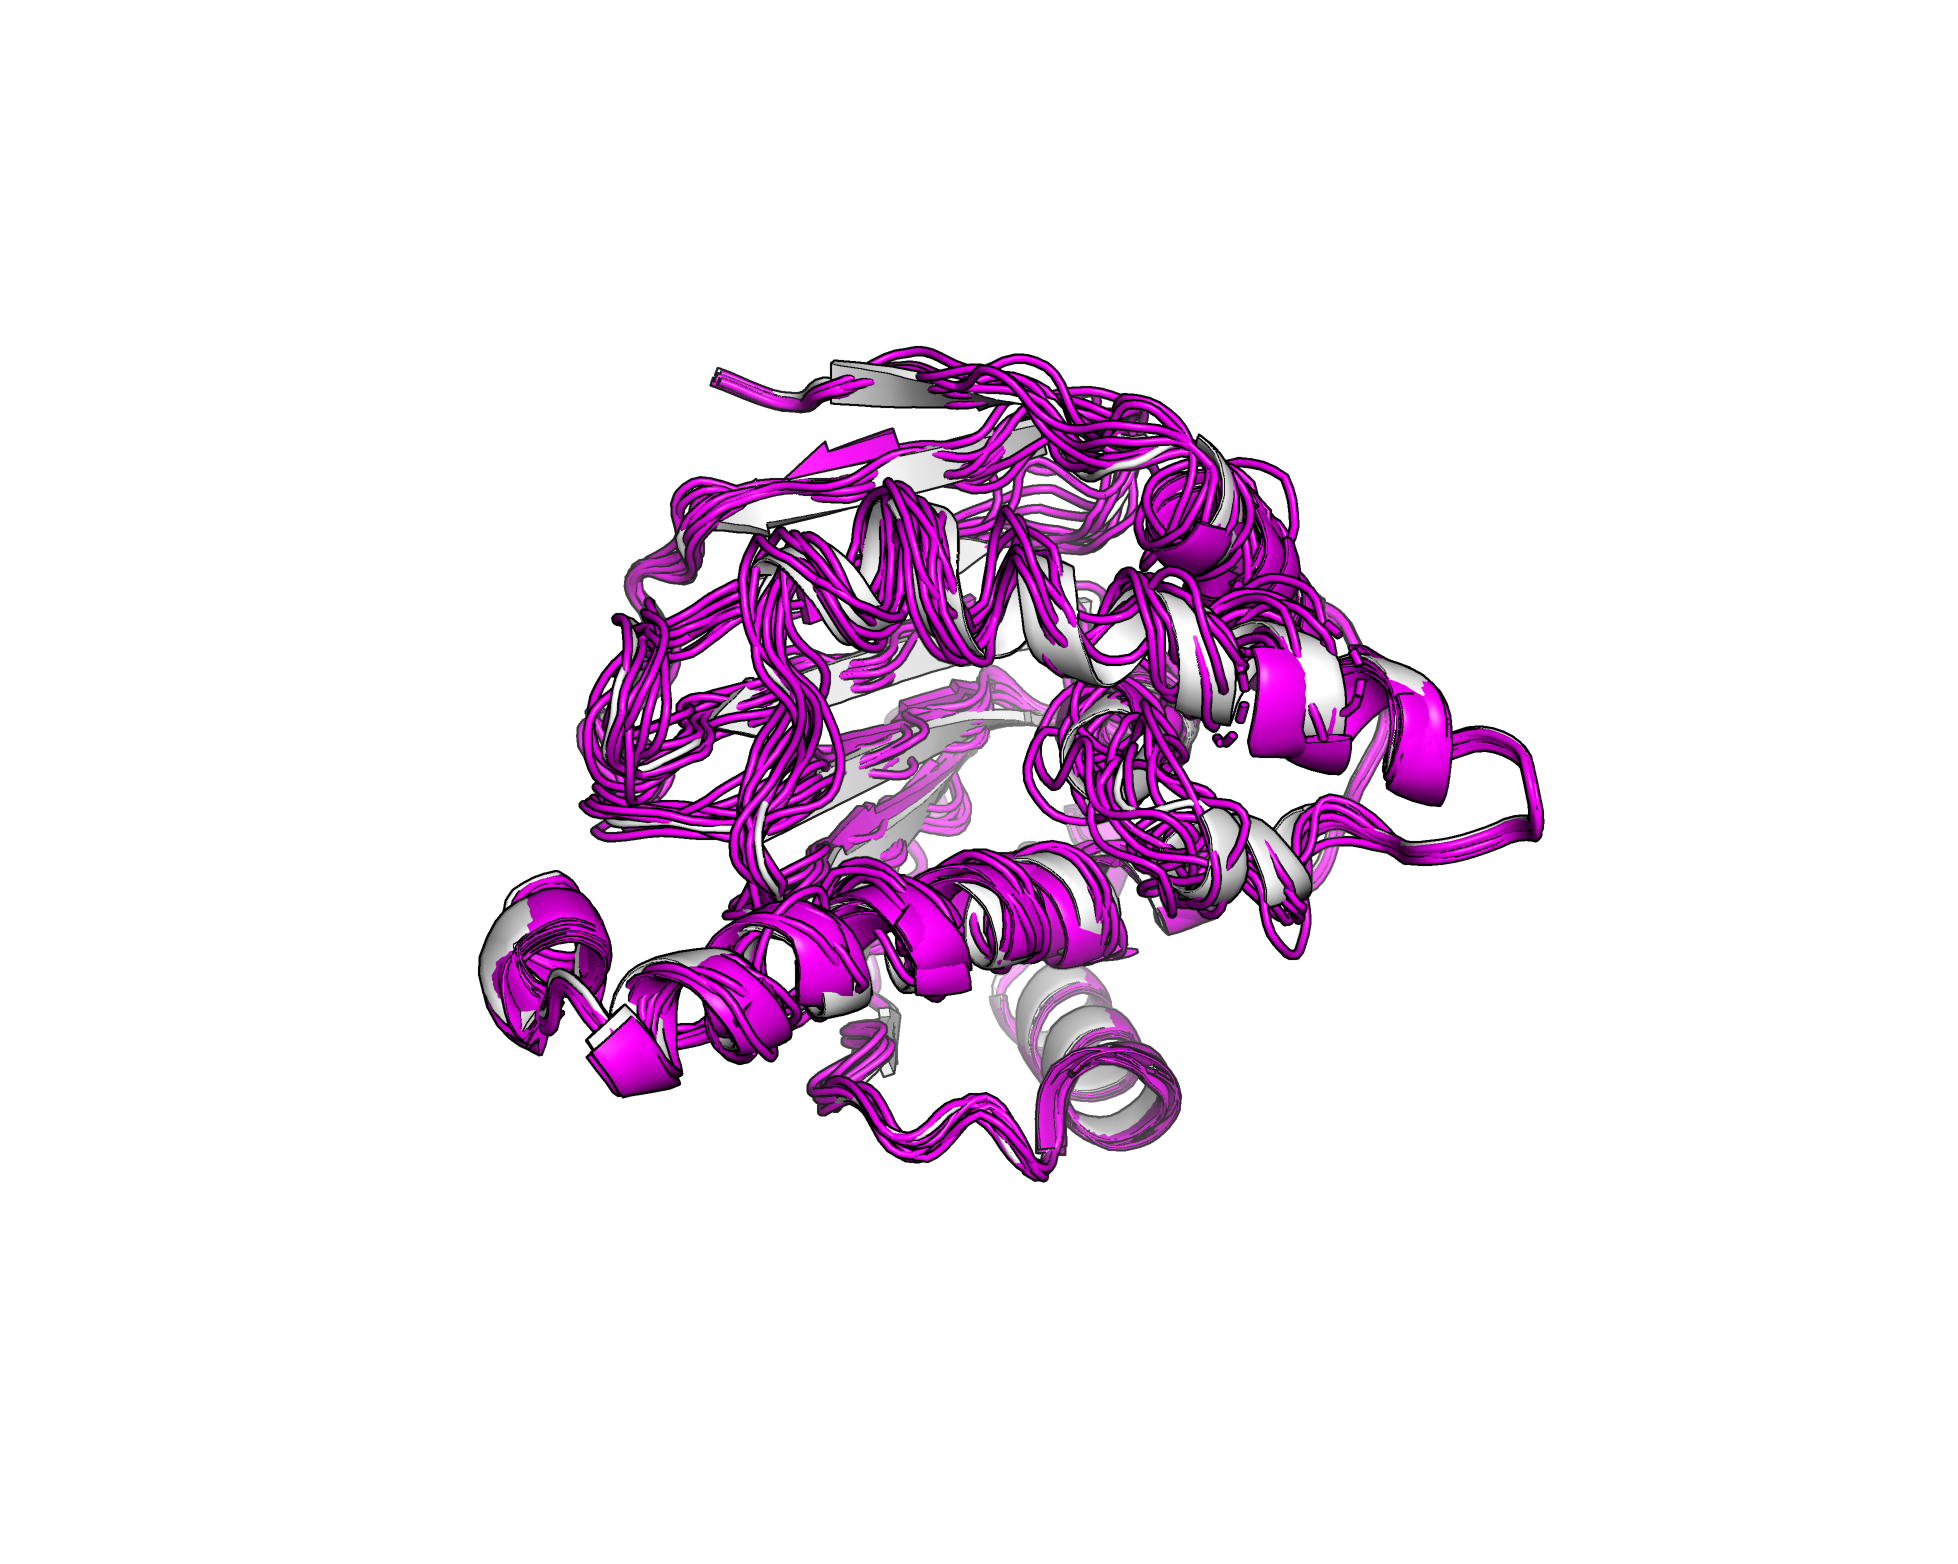

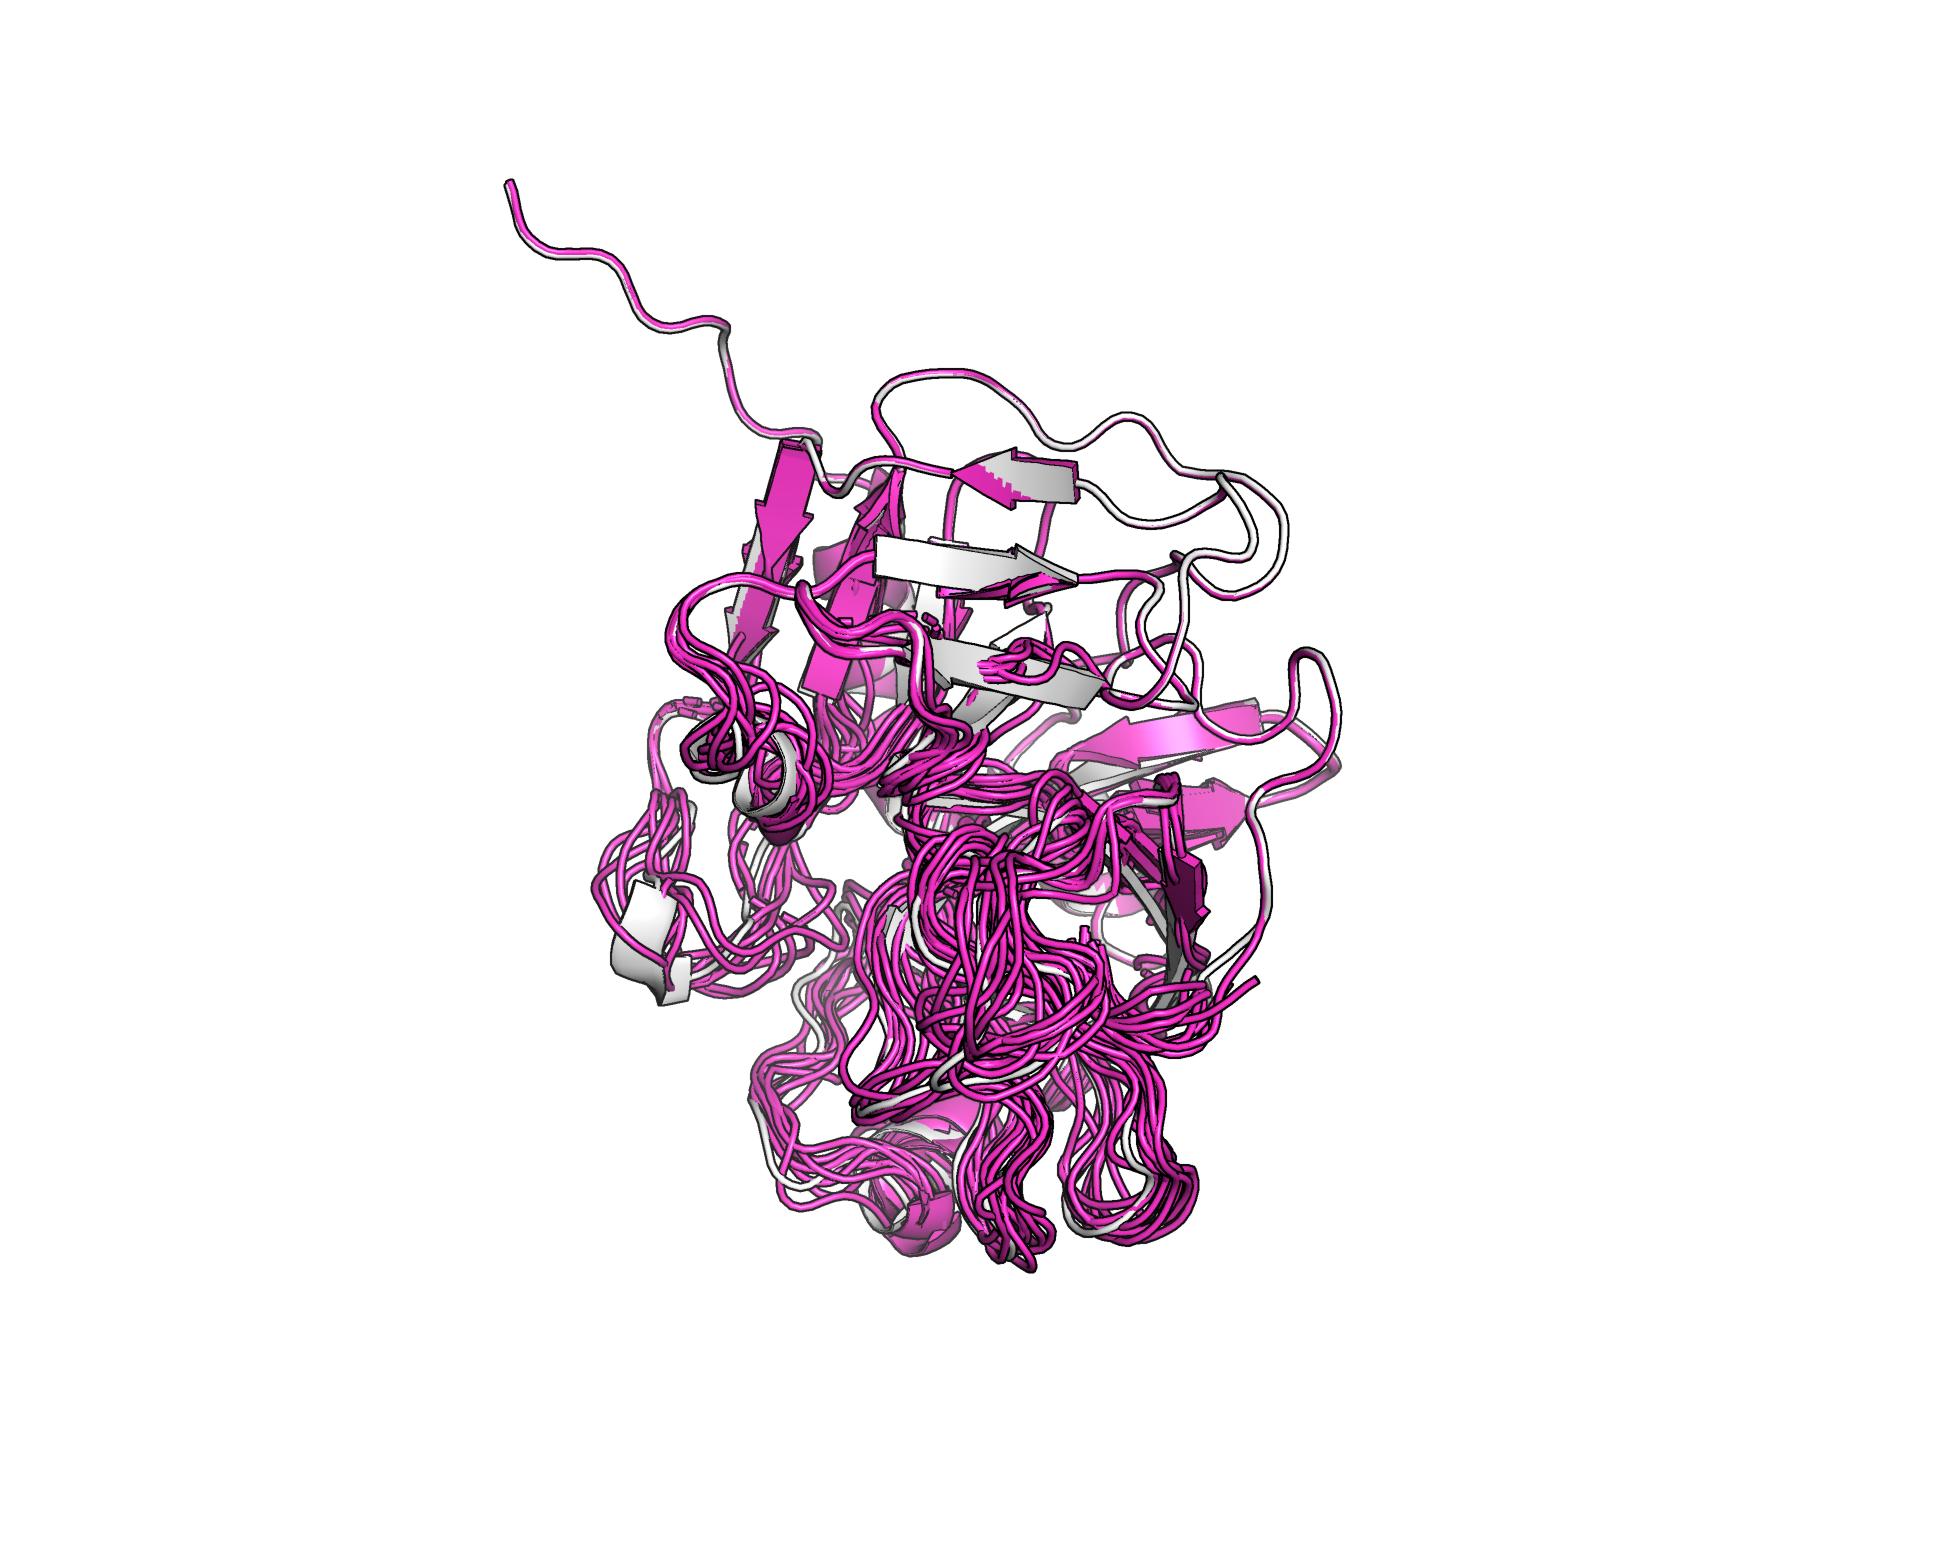

In [9]:
## To visualize the generated protein-ligand complex conformations you have just generated, you will need
## software like VMD or PyMol. You will find the following files in the protein-ligand complex folders from above:
## - Initial docked structure: Converted_Structures/[protein_code]/[protein]_dock/[ligand_code]/complex.gro
## - Relaxed ligand structure: Minimized_Structures/[protein_code]/[protein]_dock/[ligand_code]/step1_[ligand_epoch].xyz
## - Relaxed pocket structure: Minimized_Structures/[protein_code]/[protein]_dock/[ligand_code]/step2_*_[kick_random_seed].xyz
##
## Here we show you the 10 conformations generated for each of these 3 protein-ligand complexes, with the ligands
## removed from the image for clarity. These are what you will get if you have set 
## config_folder = 'Config_Files/Paper_Configs/'
## in the configuration file selection above, instead of the lower-cost 'Config_Files/Short_Test_Configs/' version.
## Feel free to visualize the structures you have personally generated above using your favorite visualization tools.

from IPython.display import Image, display

print('Display 10 conformations for:')

print('CDK2 complex (1fin_2iw8-4SP)')
im1 = Image(filename = os.path.join('Images','CDK2_1fin_2iw8-4SP.png'))

print('HSP90 complex (1uyg_2fwy-H64)')
im2 = Image(filename = os.path.join('Images','HSP90_1uyg_2fwy-H64.png'))

print('FXA complex (1ezq_2d1j-D01)')
im3 = Image(filename = os.path.join('Images','FXA_1ezq_2d1j-D01.png'))

display(im1, im2, im3)